In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../adiabatic-tides")
sys.path.append("..")

import adiabatic_tides as at
import cusp_encounters.milkyway
import cusp_encounters.encounters_math as em

%load_ext autoreload
cachedir = "../caches"

G = 43.0071057317063e-10 # Mpc (km/s)^2 / Msol 

In [28]:
mw = cusp_encounters.milkyway.MilkyWay(adiabatic_contraction=True, cachedir=cachedir)

Reading result of previous calculation from ../caches/contracted_nfw.hdf5 (i=20)


# Enclosed Mass profile

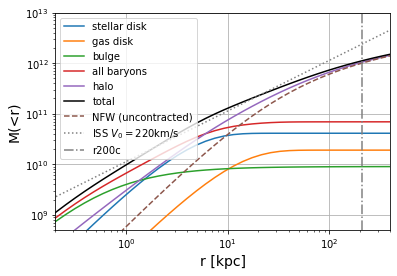

In [3]:
iss = at.profiles.IsothermalSphere(rho0=9.0e11, r0=1.)

ri = np.logspace(-4,0.5) * 200e-3

#plt.loglog(ri*1e3, mw.profile_nfw.m_of_r(ri))
#plt.loglog(ri*1e3, mw.enclosed_mass(ri*1e6, components="hsgb"), linestyle="dashed")
plt.loglog(ri*1e3, mw.enclosed_mass(ri*1e6, components="s"), label="stellar disk")
plt.loglog(ri*1e3, mw.enclosed_mass(ri*1e6, components="g"), label="gas disk")
plt.loglog(ri*1e3, mw.enclosed_mass(ri*1e6, components="b"), label="bulge")
plt.loglog(ri*1e3, mw.enclosed_mass(ri*1e6, components="sbg"), label="all baryons")
plt.loglog(ri*1e3, mw.enclosed_mass(ri*1e6, components="h"), label="halo")
plt.loglog(ri*1e3, mw.enclosed_mass(ri*1e6, components="hsbg"), label="total", color="black")

plt.loglog(ri*1e3, mw.profile_nfw.self_m_of_r(ri), label="NFW (uncontracted)", linestyle="dashed")

#plt.loglog(ri*1e3, mw.enclosed_mass(ri*1e6, components="h"), linestyle="dashed")
plt.loglog(ri*1e3, iss.m_of_r(ri), label=r"ISS $V_0=%d$km/s"%iss.v0, color="grey", linestyle="dotted")

plt.axvline(mw.profile_nfw.r200c*1e3, ls="-.", color="grey", label="r200c")

plt.xlim(2e-1,4e2)
plt.ylim(5e8,1e13)
plt.xlabel("r [kpc]", fontsize=14)
plt.ylabel("M(<r)", fontsize=14)
plt.grid()
plt.legend(fontsize=10, loc="upper left")

plt.savefig("img/mw_profiles.pdf", bbox_inches="tight")

# Orbits
## Check that the profile is stable

Note that after adding the baryons the DM profile may not be 100% in equilibrium. 

However, it seems that the adiabatic contraction takes care of this very well.

In [29]:
mw = cusp_encounters.milkyway.MilkyWay(adiabatic_contraction=True, cachedir=cachedir)
orbits = mw.create_dm_orbits(20000, nsteps=50000, rmax=400e3, addinfo=True, adaptive=True, subsamp=500)

Reading result of previous calculation from ../caches/contracted_nfw.hdf5 (i=20)
reading


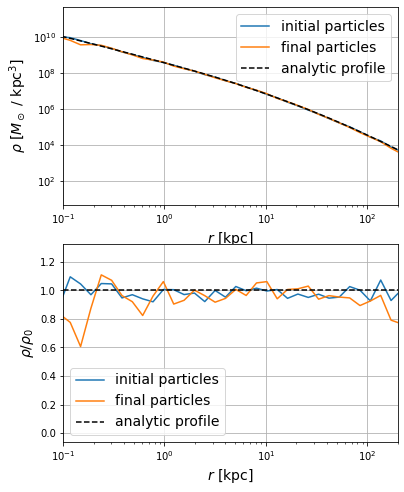

In [30]:
ri, rho_ini = em.calculate_density_profile(orbits["pos"][0]/1000., m=orbits["mass"])
ri, rho_fin = em.calculate_density_profile(orbits["pos"][-1]/1000., m=orbits["mass"])
rho_ref = mw.profile_halo.self_density(ri*1e-3)*1e-9

fig, axs = plt.subplots(2,1, figsize=(6,8))

axs[0].loglog(ri, rho_ini, label="initial particles")
axs[0].loglog(ri, rho_fin, label="final particles")
axs[0].loglog(ri, rho_ref, linestyle="dashed", color="black", label="analytic profile")

axs[1].semilogx(ri, rho_ini / rho_ref, label="initial particles")
axs[1].semilogx(ri, rho_fin / rho_ref, label="final particles")
axs[1].axhline(1., color="black", linestyle="dashed", label="analytic profile")

axs[0].set_ylabel(r"$\rho$ [$M_\odot$ / kpc$^3$]", fontsize=14)
axs[1].set_ylabel(r"$\rho / \rho_0$", fontsize=14)

for ax in axs:
    ax.set_xlabel(r"$r$ [kpc]", fontsize=14)
    ax.legend(fontsize=14)
    ax.set_xlim(1e-1, 2e2)
    ax.grid("on")

# Column Density Distribution

Note: for estimating the distributions we assign the final values of columndensities and $\chi$ and assign them at 100 different points of the orbit. This is fine, since the profile is equilibrium and we could have equally likely encountered each cusp at any point of its orbit

We are not using the column density distribution for anything, but it is still interesting to see it

In [56]:
r = np.linalg.norm(orbits["pos"][::50], axis=-1)
cdens = orbits["scolumndens"][-1] * np.ones_like(orbits["scolumndens"][::50])
chi = orbits["chi_star"][-1] * np.ones_like(orbits["chi_star"][::50])
chi_dm = orbits["chi_dm"][-1] * np.ones_like(orbits["chi_dm"][::50])

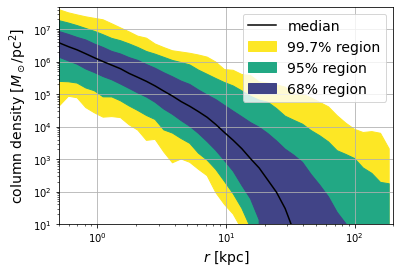

In [51]:
rbins = np.logspace(-1,np.log10(200.), 50)
ri, perc = em.get_percentile_profile(r/1000., cdens, xbins=rbins, weights=orbits["mass"]*np.ones(r.shape))

em.percentile_plot(ri, perc, ylabel=r"column density [$M_\odot / \rm{pc}^2$]")
plt.ylim(1e1, 5e7)
plt.savefig("img/radial_column_density.pdf", bbox_inches="tight")

# $\chi_*$ distribution

Note that we also check here an estimate of how much encounters of cusps with cusps can matter at most.
For this we assume that about $4\%$ of the total dark matter mass is inside of cusps. This is likely a 
strong overestimate, since tidal stripping will reduce this number, quite a lot. However, it seems that even so the cusp encounters don't matter much, but they only affect what happens at large radii.

In [80]:
%autoreload
ri, perc = em.get_percentile_profile(r/1000., chi, xbins=rbins, weights=orbits["mass"]*np.ones(r.shape))
ri, perc2 = em.get_percentile_profile(r/1000., chi+chi_dm*0.04, xbins=rbins, weights=orbits["mass"]*np.ones(r.shape))

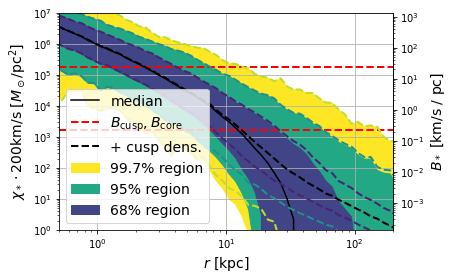

In [91]:
em.percentile_plot(ri, perc*200., ylabel=r"$\chi_* \cdot 200 \rm{km/s}$ [$M_\odot / \rm{pc}^2$]")

def chi200kms_to_Bstar(chi200kms):
    return chi200kms / 200. * mw.G * 2.*np.pi
def Bstar_to_chi200kms(chiG):
    return chiG * 200. / (mw.G * 2.*np.pi)

ax_chiG = plt.gca().secondary_yaxis('right', functions=(chi200kms_to_Bstar, Bstar_to_chi200kms))
ax_chiG.set_ylabel("$B_*$ [km/s / pc]", fontsize=14)

plt.axhline(Bstar_to_chi200kms(0.224), ls="--", label=r"$B_{\rm{cusp}}, B_{\rm{core}}$", color="red", lw=2)
plt.axhline(Bstar_to_chi200kms(23.7), ls="--", color="red", lw=2)

plt.ylim(1e0,1e7)

plt.legend(loc="lower left", fontsize=14)
plt.savefig("img/radial_chi_profile.pdf", bbox_inches="tight")

for i in (0,1,2,4,5,6):
    icol = min(i, 6-i)
    vi =[0.,0.4,0.8]
    plt.plot(ri, perc2[:,i]*200., linestyle="dashed", color=plt.get_cmap("viridis_r")(vi[icol]+0.1),lw=2)
plt.plot(ri, perc2[:,3]*200., linestyle="dashed", color="black",lw=2, label="+ cusp dens.")
plt.legend(loc="lower left", fontsize=14)

plt.savefig("img/radial_chi_plus_cusp_profile.pdf", bbox_inches="tight")

# $\chi_{\rm{cusp}}$ distribution

In [92]:
ri, perc = em.get_percentile_profile(r/1000., chi_dm*0.04, xbins=rbins, weights=orbits["mass"]*np.ones(r.shape))

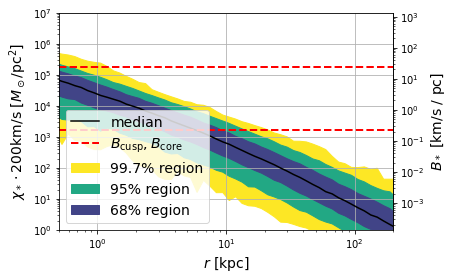

In [93]:
em.percentile_plot(ri, perc*200., ylabel=r"$\chi_* \cdot 200 \rm{km/s}$ [$M_\odot / \rm{pc}^2$]")

def chi200kms_to_Bstar(chi200kms):
    return chi200kms / 200. * mw.G * 2.*np.pi
def Bstar_to_chi200kms(chiG):
    return chiG * 200. / (mw.G * 2.*np.pi)

ax_chiG = plt.gca().secondary_yaxis('right', functions=(chi200kms_to_Bstar, Bstar_to_chi200kms))
ax_chiG.set_ylabel("$B_*$ [km/s / pc]", fontsize=14)

plt.axhline(Bstar_to_chi200kms(0.224), ls="--", label=r"$B_{\rm{cusp}}, B_{\rm{core}}$", color="red", lw=2)
plt.axhline(Bstar_to_chi200kms(23.7), ls="--", color="red", lw=2)

plt.ylim(1e0,1e7)

plt.legend(loc="lower left", fontsize=14)
plt.savefig("img/radial_chi_cusps_profile.pdf", bbox_inches="tight")